In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import chi2_contingency

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# Load Data
In this section we load the data from the data dir and concat corresponding data frames for the analysis.

In [117]:
# Read provided data
x_train = pd.read_csv("../data/raw/train_values.csv")
y_train = pd.read_csv("../data/raw/train_labels.csv")
x_test = pd.read_csv("../data/raw/test_values.csv")

# Concat x_train and y_train for analysis: Drop building_id since its redundant then
df_train = pd.concat([x_train, y_train.drop(["building_id"], axis=1)], axis=1)

# Print information about shape
print(f"Shape of train_values.csv: {x_train.shape}")
print(f"Shape of train_labels.csv: {y_train.shape}")
print(f"Shape of concat df_train to analyse: {df_train.shape}")

# Preview df
df_train.head(5)

Shape of train_values.csv: (260601, 39)
Shape of train_labels.csv: (260601, 2)
Shape of concat df_train to analyse: (260601, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

# Correlation between Numerical Features and Target
In this section we analyse the linear correlation between numerical features and the target variable using Person's correlation factor.

In [119]:
# Compute pearson correlation for all numerical features
corr = df_train._get_numeric_data().corr()

# Get only correlation from features to target
corr_features_to_target = corr.loc[:, "damage_grade"]
# Convert to pandas DataFrame and drop row 'damage_grade', since corr with itself is always 1
corr_features_to_target = pd.DataFrame(corr_features_to_target)
corr_features_to_target = corr_features_to_target.round(decimals=4)
corr_features_to_target.drop(["damage_grade", "building_id"], inplace=True)

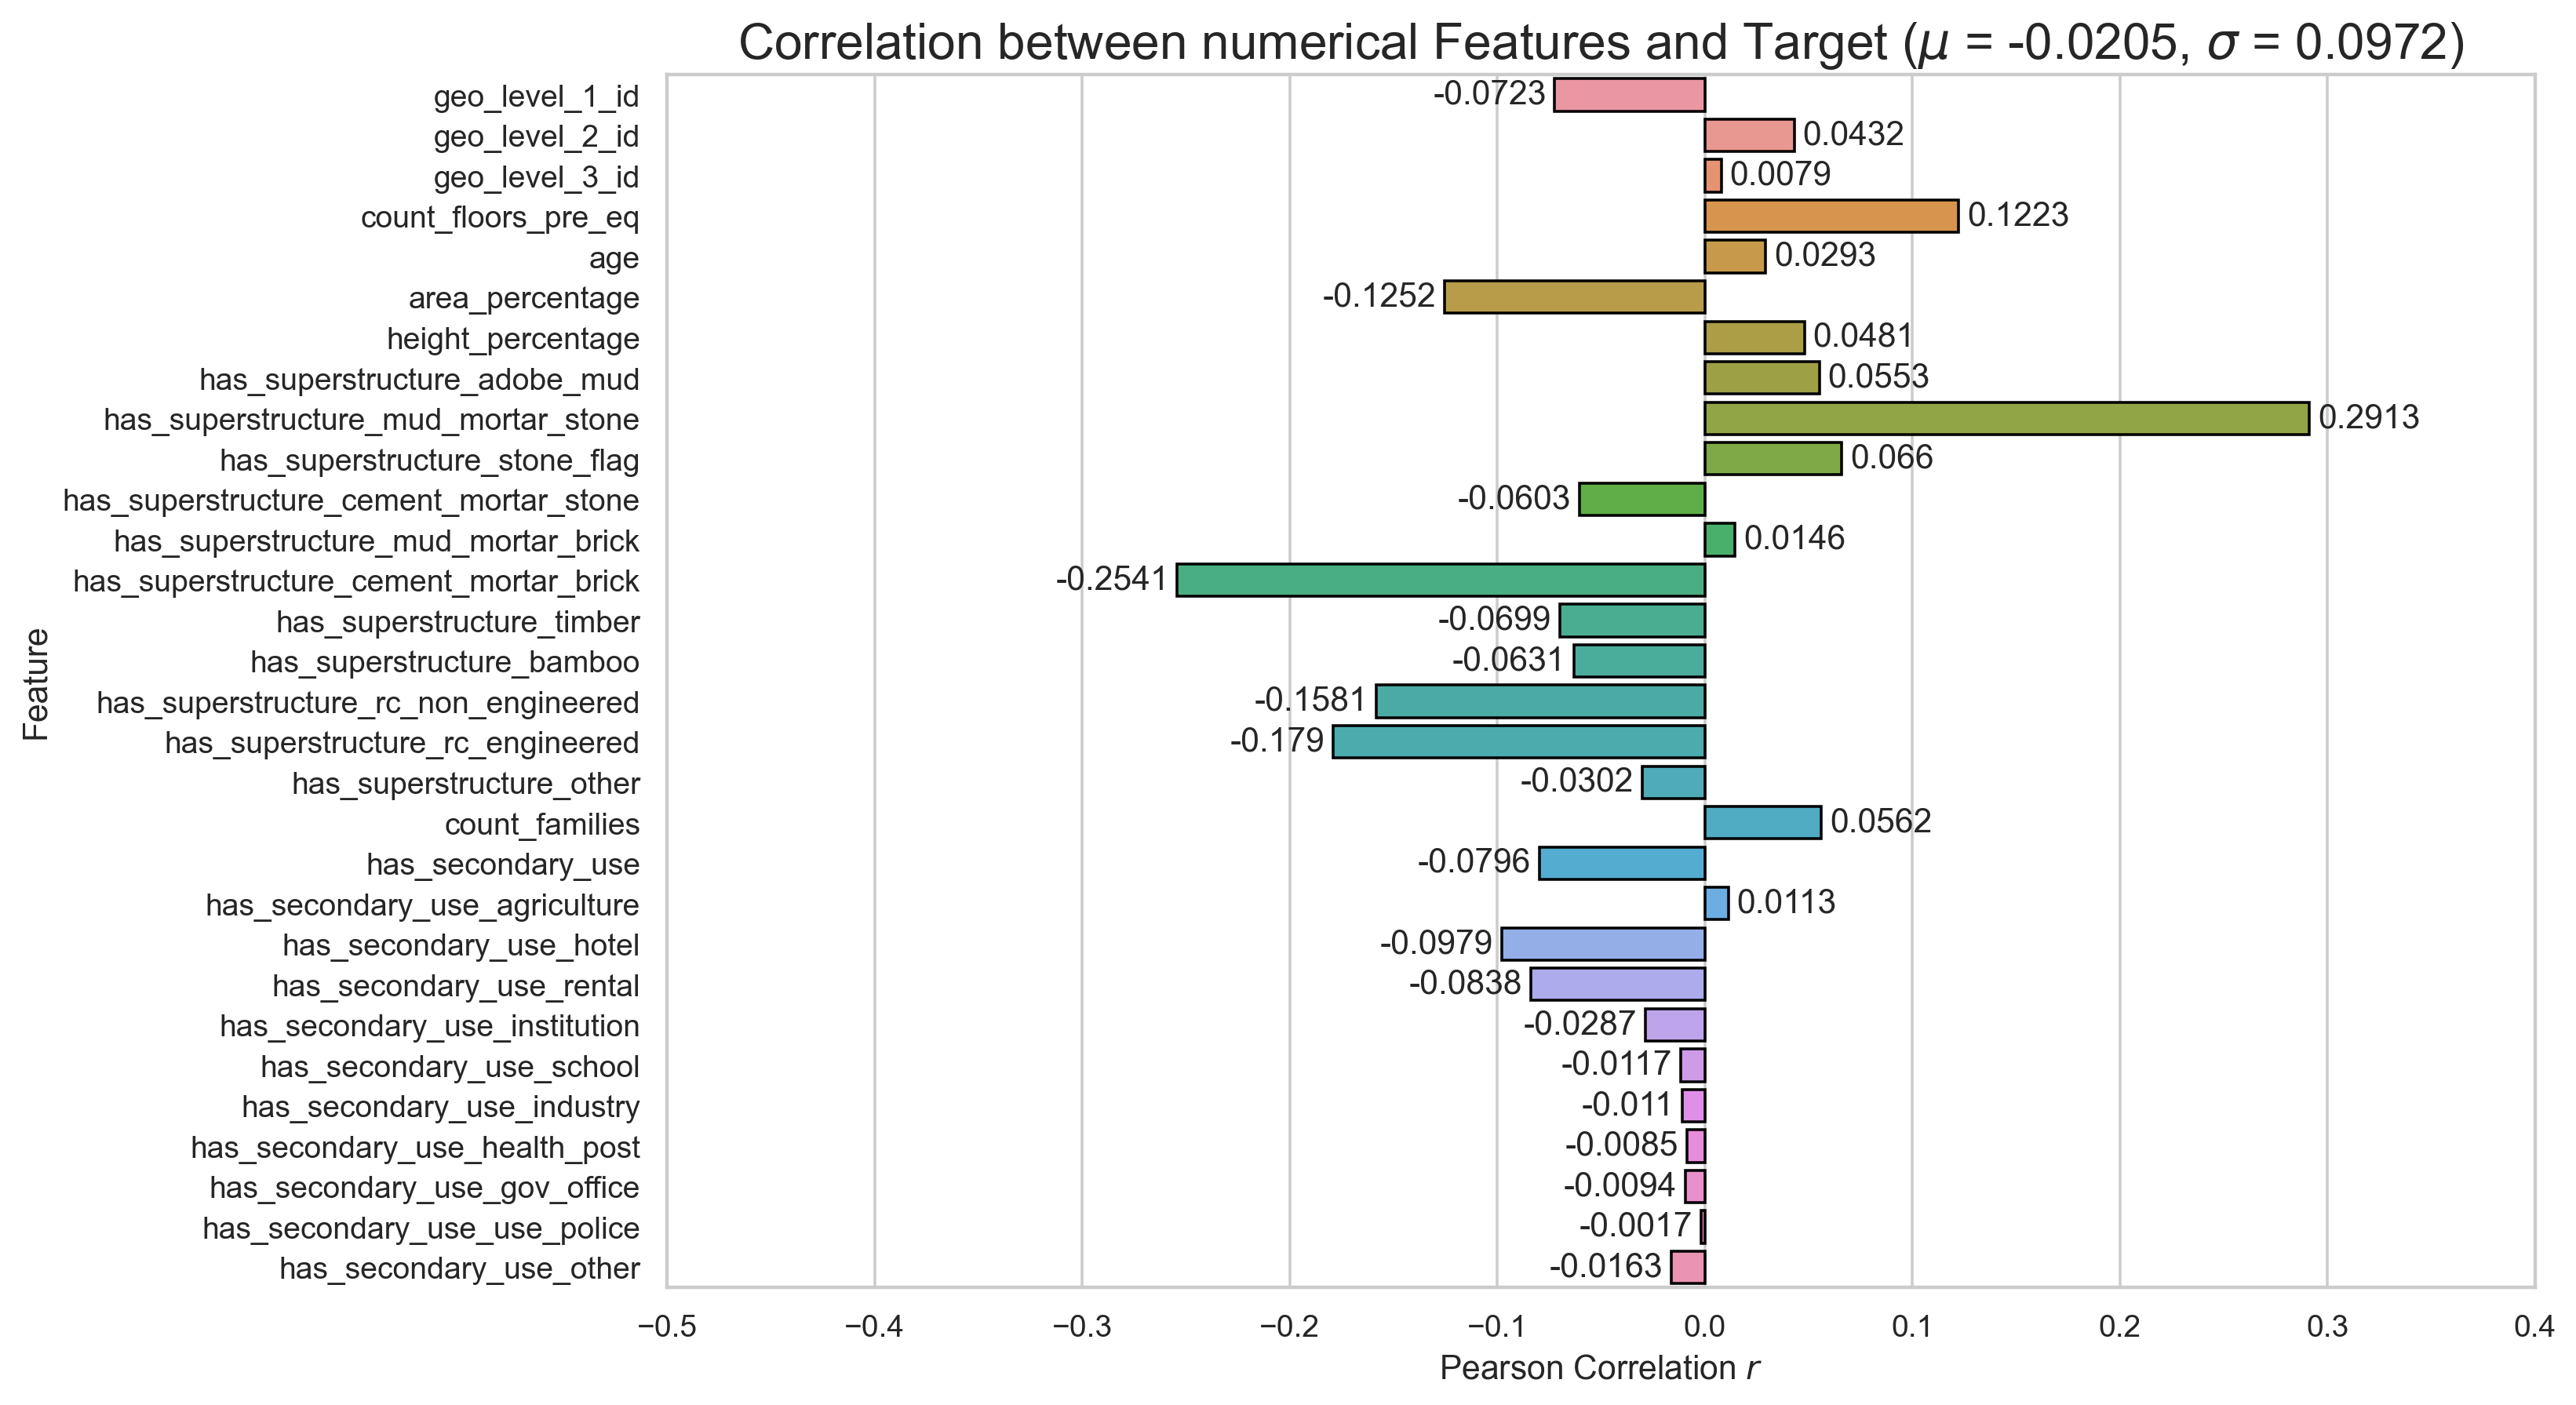

In [120]:
# Plot settings
plt.figure(figsize=(12,8), dpi=256)
# Compute mean and standard deviation of correlations
avg_corr = round(np.mean(corr_features_to_target.values), 4)
std_corr = round(np.std(corr_features_to_target.values), 4)
plt.title(f"Correlation between numerical Features and Target ($\mu$ = {avg_corr}, $\sigma$ = {std_corr})", size=18)
g = sns.barplot(data=corr_features_to_target, x="damage_grade", y=corr_features_to_target.index, edgecolor="black")
g.bar_label(g.containers[0], padding=3)
plt.xticks(np.arange(-0.5, 0.5, 0.1))
plt.xlabel("Pearson Correlation $r$")
plt.ylabel("Feature")
plt.show()

## Findings
* Positive Correlation:
    * Highest positive correlation of $0.2913$ between **has_superstructure_mud_mortar_stone** and target variable **damage_grade**: If the superstructure was made of Mud Mortar - Brick it is more likely that the damage grade is high, i.e. the damages are higher.
    * Also high positive correlation of $0.1223$ between **count_floors_pre_eq** and target variable: Probably if the number of floors in the building increases, the more likely the chance of higher damages.

* Negative Correlation:
    * Highest negative correlation of $-0.2541$ between **has_superstructure_cement_mortar_brick** and target variable **damage_grade**.
    * Also high negative correlation between **has_superstructure_rc_engineered** to target variable ($-0.179$) and between **has_superstructure_rc_non_engineered** to target variable ($-0.1581$): If the superstructure was made of reinforced engineered / non-engineered concrete, it is less likely to have higher damages.
    * Also high negative correlation between **area_percentage** and the target variable ($-0.1252$): If the normalized area of the building footprint increases, the damage grade decreases, i.e. it is less likely to have high damages.
    * Also buildings with secondary use as a hotel ($-0.0979$) **has_secondary_use_hotel** is also less likely to have higher damages from earthquakes.

# Grouped Density I: Discrete Numerical Features I
In this section we analyse the occurrences of the features grouped by the target variable

In [121]:
# First for numerical Values
df_train_numeric = df_train._get_numeric_data()
df_train_numeric.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,1,0,...,0,0,0,0,0,0,0,0,0,3


In [122]:
# First get columns to analyse
# We first get all numerical columns and then exclude columns that does not fit the grouped barchart analysis
cols_to_analyse = list(df_train_numeric.columns)#.remove("building_id")
cols_to_remove = ["building_id", "geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "damage_grade"]
cols_for_kde = ["age", "area_percentage", "height_percentage"]
cols_to_analyse = [x for x in cols_to_analyse if x not in (cols_to_remove + cols_for_kde)]

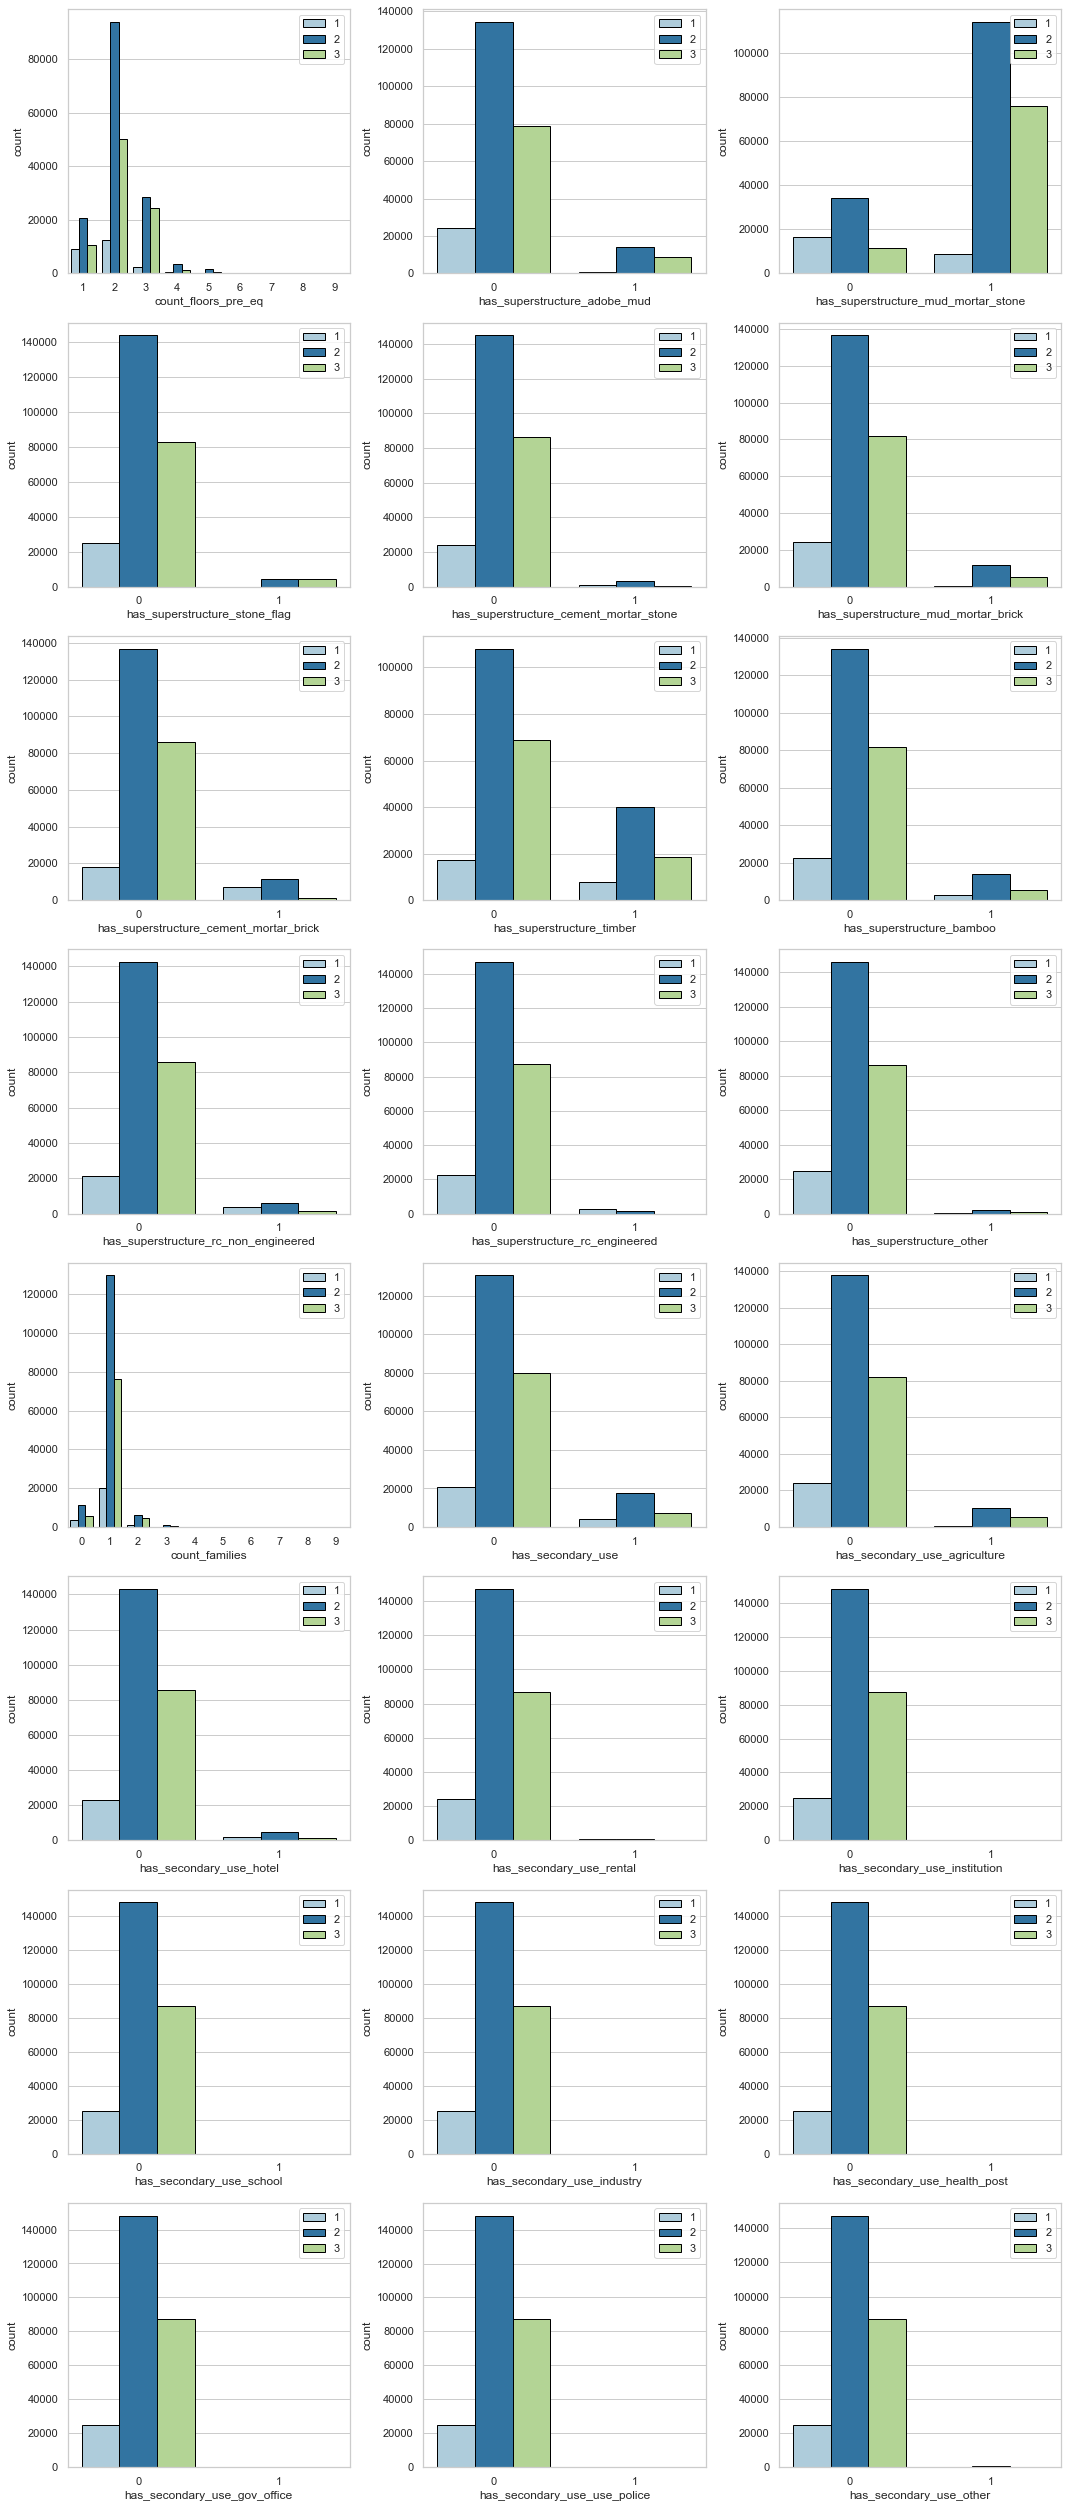

In [123]:
# Dynamically set size of subplots
NCOLS: int = 3
NROWS: int = math.ceil(len(cols_to_analyse)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(15, 35), nrows=NROWS, ncols=NCOLS)
for feature, ax in zip(cols_to_analyse, axes.flatten()):
    g=sns.countplot(data=df_train_numeric, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Findings
* Very high proportion of high damage grade $3$ if **has_superstructure_mud_mortar_stone** is true, i.e. if mud mortar stone is used as superstructure (also in line with the correlation analysis above).
* Also very high proportion of high damage grade $3$ if **count_floors_pre_eq**, i.e. if building is very tall (many floors) more likely to have very high earthquake damage instead of low damage.
* Very interesting that there are almost no secondary uses of the buildings, i.e. **has_secondary_use_x for x in {institution, school, industry, health_post, gov_office, use_police, use_other}**. So we can drop them out since it has no information at all (value is almost everytime 0)

# Grouped Density II: Discrete Numerical Features II

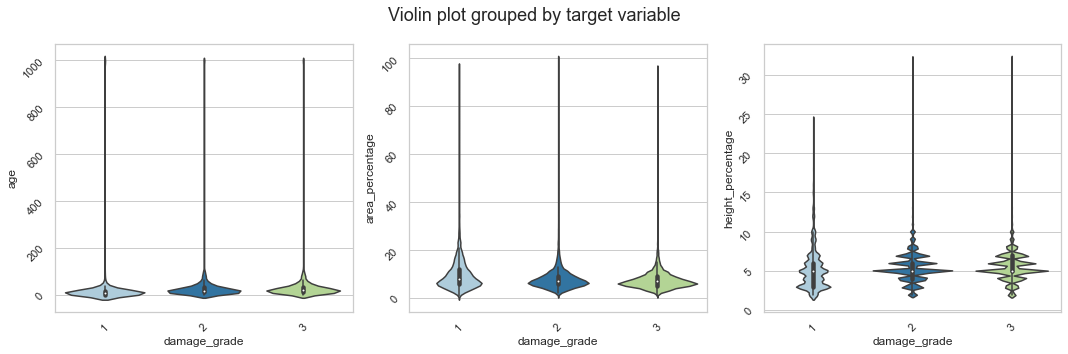

In [124]:
# Analog for numerical columns with a continous and wider domain
# Dynamically set size of subplots
NCOLS: int = 3
NROWS: int = math.ceil(len(cols_for_kde)/NCOLS)

# Convert target variable to categorical for plotting
df_train_numeric["damage_grade"] = df_train_numeric["damage_grade"].astype("category")

# Plot settings
fig, axes = plt.subplots(figsize=(15, 5), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Violin plot grouped by target variable", size=18)
for feature, ax in zip(cols_for_kde, axes.flatten()):
    sns.violinplot(data=df_train_numeric, y=feature, x="damage_grade", ax=ax)
    ax.tick_params(labelrotation=45)
plt.tight_layout()
plt.show()

## Findings
- TBD

# Grouped Densitiy III: Categorical Features

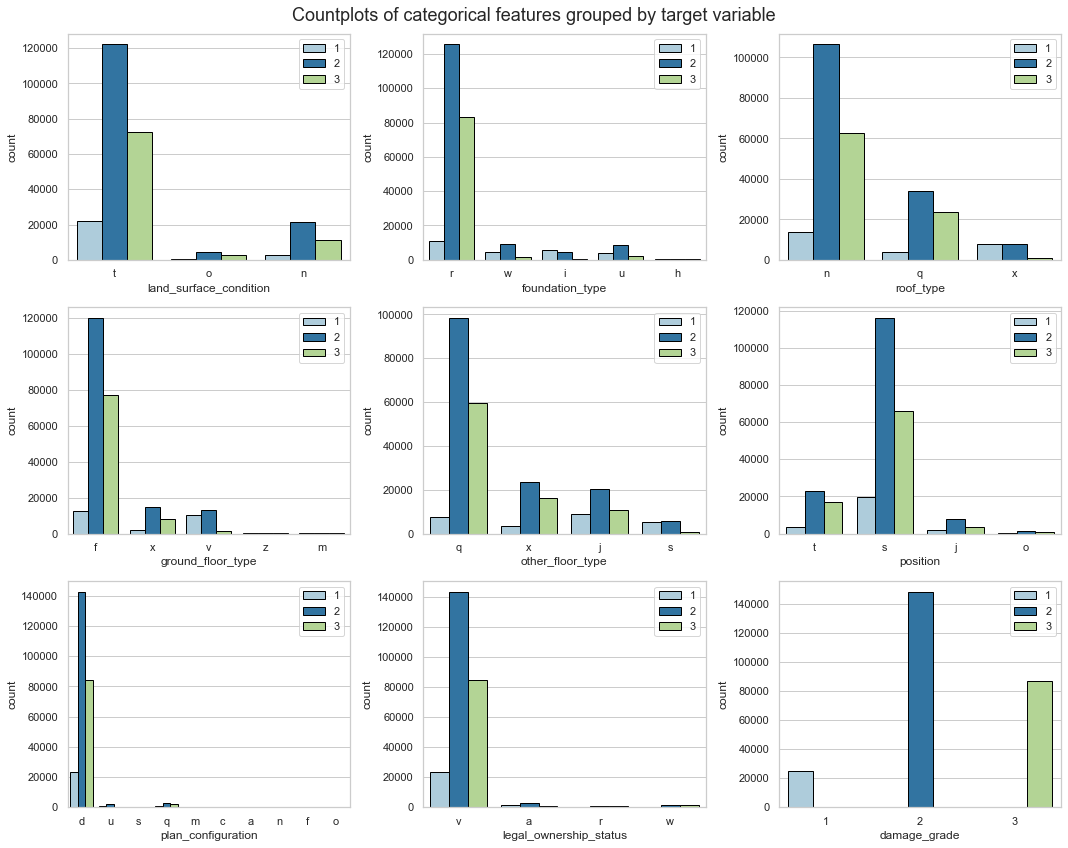

In [125]:
# First get columns to analyse (here: categorical ones)
categoric_columns = list(df_train.select_dtypes(include=['object']).columns)#.remove("building_id")
categoric_columns = categoric_columns + ["damage_grade"]
df_train_categoric = df_train[categoric_columns]

# Dynamically set size of subplots
NCOLS: int = 3
NROWS: int = math.ceil(len(categoric_columns)/NCOLS)

# Plot settings
fig, axes = plt.subplots(figsize=(15, 12), nrows=NROWS, ncols=NCOLS)
fig.suptitle("Countplots of categorical features grouped by target variable", size=18)
for feature, ax in zip(categoric_columns, axes.flatten()):
    g=sns.countplot(data=df_train_categoric, x=feature, hue="damage_grade", edgecolor="black", ax=ax)
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Findings
- Feature **plan_configuration** has almost no other realization than 'd' and 'q'.
- Similar for feature *legal_ownership_status* with realization 'v'.
- High proportion of high damaged buildings where building is in **position** 't'.

# Chi-Squared-Test for Categorical Features and Target Variable
We assume here that the target variable is categorical and therefore we can use the Chi Squared Test to test for independency between all categorical features and the target variable.

In [126]:
# Define significance level
ALPHA = 0.05

# Create empty list to populate later
feat_1 = []
feat_2 = []
p_list = []
chi_list = []
dof_list = []
res_list = []

# Iterate through all categorical columns and perform chi square test
for feature in categoric_columns:
    # Create contingency table
    contingency_table = pd.crosstab(df_train_categoric[feature],
                                df_train_categoric["damage_grade"])
    # Perform chi square test and get test statistic, p-value, degrees of freedom and expected values
    chi, p, dof, expected = chi2_contingency(contingency_table)
    # Populate lists
    feat_1.append(feature)
    feat_2.append("damage_grade")
    p_list.append(p)
    chi_list.append(chi)
    dof_list.append(dof)
    res_list.append(p < ALPHA)

# Populate Result DataFrame and view it
chi_test_results = pd.DataFrame({"Feature 1": feat_1, "Feature 2": feat_2,
                                "Test Statistic" : chi_list, "Degrees of Freedom": dof_list,
                                "p-value": p_list, "Reject Nullhypothesis": res_list})
# Round to 4 decimal places
chi_test_results = chi_test_results.round(4)
chi_test_results

,Feature 1,Feature 2,Test Statistic,Degrees of Freedom,p-value,Reject Nullhypothesis
0,land_surface_condition,damage_grade,449.6714,4,0.0,True
1,foundation_type,damage_grade,48547.1607,8,0.0,True
2,roof_type,damage_grade,30251.4193,4,0.0,True
3,ground_floor_type,damage_grade,36430.8490,8,0.0,True
4,other_floor_type,damage_grade,31487.3919,6,0.0,True
5,position,damage_grade,1079.9274,6,0.0,True
6,plan_configuration,damage_grade,1734.1171,18,0.0,True
7,legal_ownership_status,damage_grade,2586.1628,6,0.0,True
8,damage_grade,damage_grade,521202.0000,4,0.0,True


## Findings
- We can reject the null hypothesis $H_0$ for all categorical features with the target variable at a significance level of $\alpha = 0.05$ and therefore we have evidence that their are not independent.